Oz Kilic  
COMP 5118 Project

# Data processor

Importing the libraries, setting the position tensor saving location, creating the data parser object, defining some helper functions:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen
import numpy as np
import math
from scipy.ndimage import gaussian_filter
import sympy as sp
import pandas as pd
import csv
import glob, os, shutil
from tqdm import tqdm
import time
import warnings


frames_dataset_location = "360" # the 360 dataset must be downloaded 
positions_export_location = "position_tensors"

parser = Sbopen()

def get_voronoi(frame, blur=False, blur_sigma=5):
    voronoi = np.zeros((80, 120))
    for i in range(80):
        for j in range(120):
            min_dist = math.inf
            min_dist_team = False
            for row_id, row in frame.iterrows():
                # print([row.x, row.y])
                dist = math.dist([j, i], [row.x, row.y])
                if dist < min_dist:
                    min_dist = dist
                    min_dist_team = row.teammate
            
            if min_dist_team:
                voronoi[i,j] = 1
    if blur:
        return gaussian_filter(voronoi, sigma=blur_sigma)
    return voronoi

def get_positions(frame, blur=False, blur_sigma=3):
    actor = np.zeros((80, 120))
    team = np.zeros((80, 120))
    enemy = np.zeros((80, 120))
    for row_id, row in frame.iterrows():
        if row.actor:
            active = actor
        elif row.teammate:
            active = team
        else:
            active = enemy
            
        x = max(min(int(row.x), 119), 0)
        y = max(min(int(row.y), 79), 0)
            
        j_start = max(0, x-3)
        j_end = min(119, x+3)
        i_start = max(0, y-3)
        i_end = min(79, y+3)
        for i in range(i_start+1, i_end):
            for j in range(j_start+1, j_end):
                active[i,j] = 1
                
        active[i_start, max(0,x-1):min(119,x+2)] = 1
        active[i_end, max(0,x-1):min(119,x+2)] = 1
        
        active[max(0,y-1):min(79,y+2), j_start] = 1
        active[max(0,y-1):min(119,y+2), j_end] = 1
        
        active[max(0,y-2), max(0,x-2)] = 1
        active[max(0,y-2), min(119,x-2)] = 1
        active[min(79,y+2), max(0,x-2)] = 1
        active[min(79,y+2), min(119,x-2)] = 1
        
    if blur:
        actor = gaussian_filter(actor, sigma=blur_sigma)
        team = gaussian_filter(team, sigma=blur_sigma)
        enemy = gaussian_filter(enemy, sigma=blur_sigma)
    
    return (actor, team, enemy)

def encode_angle(angle_radian, n_group=24, sensitivity=6):
    angle = (round(sp.N(float(angle_radian)/sp.pi), sensitivity) * -180) % 360 # the sign is flipped due to the angle going clockwise in the dataset
    # print(angle)
    unit_range = 360 / n_group
    offset = unit_range / 2
    angle_group_id = None
    for i in range(1, n_group+1):
        # print(f"it must be between {(i-1)*unit_range-offset} and {(i * unit_range)-offset}")
        threshold_min = (i-1)*unit_range-offset
        threshold_max = (i * unit_range)-offset
        
        if threshold_min < 0:
            check = (360+threshold_min <= angle < 360) or (threshold_min <= angle < threshold_max)
        else:
            check = threshold_min <= angle < threshold_max
        
        if check:
            angle_group_id = i
            break
    
    angle_discretized = (angle_group_id-1) * unit_range
    return (round(np.sin(np.deg2rad(angle_discretized)), sensitivity), round(np.cos(np.deg2rad(angle_discretized)), sensitivity))

## Processing positions

This block processes player positions for pass events, obtains 4-channel images (pitch control voronoi diagram, actor's location, teammates' location, opponents' location), and saves them. Note that, apart from taking a long time to process, the position images of the first 100 matches take up about 25 GB of space.

In [3]:
overwrite = False
match_limit = 100 # None to deactivate

for file_index, file_name in enumerate(tqdm(glob.glob(f"{frames_dataset_location}/*.json"))):
    if match_limit is not None and file_index >= match_limit:
        break
    match_id = int(file_name.split("\\")[1].split(".json")[0])
    # print(match_id)
    
    if os.path.exists(f"{positions_export_location}/{match_id}"):
        new_folder = False
        if overwrite:
            shutil.rmtree(f"{positions_export_location}/{match_id}")
            os.makedirs(f"{positions_export_location}/{match_id}")
    else:
        new_folder = True
        os.makedirs(f"{positions_export_location}/{match_id}")
        
    
    events, related, freeze, tactics = parser.event(match_id)
    frames, visible = parser.frame(match_id)
    passes = events[events.type_id == 30]
    
    for row_id, row in passes.iterrows():
        event_id = row.id
        if not new_folder and (not overwrite and os.path.isfile(f"{positions_export_location}/{match_id}/{event_id}.npy")):
            continue

        frame = frames[frames.id == event_id]
        if frame.shape[0] > 0:
            voronoi = get_voronoi(frame, blur=True, blur_sigma=5)
            positions = get_positions(frame, blur=True, blur_sigma=1)
            positions_tensor = np.insert(positions, 3, voronoi, 0)
            # print(positions_tensor)
            # plt.imshow(positions_tensor[0])
            # plt.show()
            # plt.imshow(positions_tensor[1])
            # plt.show()
            # plt.imshow(positions_tensor[2])
            # plt.show()
            # plt.imshow(positions_tensor[3])
            with open(f"{positions_export_location}/{match_id}/{event_id}.npy", "wb") as file:
                np.save(file, positions_tensor)
    #     break
    # break 

 68%|██████████████████████████████████████████████████                       | 100/146 [22:39:29<10:25:22, 815.70s/it]


## Processing event data

This block processes event data that correspond to the saved positions. It transforms certain features using one-hot encoding or angle encoding.

In [4]:
overwrite = True

dataset_file = "dataset_processed.csv"

features = ["match_id", "id", "pass_length", "pass_height_ground", "pass_height_low", "pass_height_high", "pass_angle", "pass_angle_processed", "angle_sin", "angle_cos", 
            "technique_inswinging", "technique_outswinging", "technique_straight", "technique_through_ball", "technique_regular", 
            "type_corner", "type_free_kick", "type_goal_kick", "type_interception", "type_kick_off", "type_recovery", "type_throw_in", "type_regular",
            "body_drop_kick", "body_head", "body_keeper_arm", "body_left_foot", "body_other", "body_right_foot", "body_no_touch", 
            "outcome_incomplete", "outcome_injury", "outcome_out", "outcome_offside", "outcome_unknown", "outcome_complete", 
            "miscommunication", "cutback", "shot_assist", "goal_assist", "deflected",
            "x", "y", "end_x", "end_y"]

pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore") # this suppresses a pandas warning here, can be dangerous

if os.path.isfile(dataset_file) and overwrite:
    os.remove(dataset_file)
    
if not os.path.isfile(dataset_file):
    with open(dataset_file, mode="w", newline="", encoding="utf-8") as f:
        csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(features)

for match_folder in tqdm(glob.glob(f"{positions_export_location}/*")):
    time.sleep(1)
    match_id = match_folder.replace(f"{positions_export_location}\\", "")
    pass_events = [event.replace(f"{positions_export_location}\\{match_id}\\", "").replace(".npy", "") for event in glob.glob(f"{positions_export_location}\\{match_id}\\*.npy")]
    # print(len(pass_events))
    events, _, _, _ = parser.event(match_id)
    # print(events.columns)
    filtered_events = events[events.id.isin(pass_events)]
    # print(set(filtered_events.outcome_name.tolist()))
    # print(set(filtered_events.sub_type_name.tolist()))
    # print("successful", filtered_events[filtered_events.outcome_name.isnull()].shape)
    # print("non-successful", filtered_events[~filtered_events.outcome_name.isnull()].shape)
    # print("incomplete", filtered_events[filtered_events.outcome_name == "Incomplete"].shape)
    # # print("deflected complete", filtered_events[(~filtered_events.pass_deflected.isnull()) & (filtered_events.outcome_name.isnull())].shape)
    # print("regular pass, no kick off or corner or something", filtered_events[filtered_events.sub_type_name.isnull()].shape)
    # print("non-regular pass", filtered_events[~filtered_events.sub_type_name.isnull()].shape)
    # # try:
    # #     print("pass miscommunication", filtered_events[~filtered_events.pass_miscommunication.isnull()].shape)
    # # except:
    # #     pass
    
    # display(filtered_events.head(3))
    
    filtered_events.loc[:,"match_id"] = match_id
    
    # filtered_events.loc[:,["angle_encoded"]] = filtered_events[["pass_angle"]].applymap(lambda row: encode_angle(row))
    
    filtered_events.loc[:,"pass_angle_processed"] = filtered_events.pass_angle.apply(lambda x: (round(sp.N(float(x)/sp.pi), 6) * -180) % 360)
    
    encoded_angles = filtered_events.pass_angle.apply(encode_angle)
    filtered_events.loc[:,["angle_sin"]] = [angle[0] for angle in encoded_angles]
    filtered_events.loc[:,["angle_cos"]] = [angle[1] for angle in encoded_angles]
    
    # print(filtered_events)
    
    filtered_events.loc[:,["pass_height_ground"]] = np.where(filtered_events.pass_height_id == 1, 1, 0)
    filtered_events.loc[:,["pass_height_low"]] = np.where(filtered_events.pass_height_id == 2, 1, 0)
    filtered_events.loc[:,["pass_height_high"]] = np.where(filtered_events.pass_height_id == 3, 1, 0)
    
    filtered_events.loc[:,["technique_inswinging"]] = np.where(filtered_events.technique_id == 104, 1, 0)
    filtered_events.loc[:,["technique_outswinging"]] = np.where(filtered_events.technique_id == 105, 1, 0)
    filtered_events.loc[:,["technique_straight"]] = np.where(filtered_events.technique_id == 107, 1, 0)
    filtered_events.loc[:,["technique_through_ball"]] = np.where(filtered_events.technique_id == 108, 1, 0)
    filtered_events.loc[:,["technique_regular"]] = np.where(filtered_events.technique_id.isnull(), 1, 0)
    
    filtered_events.loc[:,["type_corner"]] = np.where(filtered_events.sub_type_id == 61, 1, 0)
    filtered_events.loc[:,["type_free_kick"]] = np.where(filtered_events.sub_type_id == 62, 1, 0)
    filtered_events.loc[:,["type_goal_kick"]] = np.where(filtered_events.sub_type_id == 63, 1, 0)
    filtered_events.loc[:,["type_interception"]] = np.where(filtered_events.sub_type_id == 64, 1, 0)
    filtered_events.loc[:,["type_kick_off"]] = np.where(filtered_events.sub_type_id == 65, 1, 0)
    filtered_events.loc[:,["type_recovery"]] = np.where(filtered_events.sub_type_id == 66, 1, 0)
    filtered_events.loc[:,["type_throw_in"]] = np.where(filtered_events.sub_type_id == 67, 1, 0)
    filtered_events.loc[:,["type_regular"]] = np.where(filtered_events.sub_type_id.isnull(), 1, 0)
    
    
    if "pass_miscommunication" in events.columns:
        filtered_events["miscommunication"] = np.where(~filtered_events.pass_miscommunication.isnull(), 1, 0)
    else:
        filtered_events["miscommunication"] = 0
    
    if "pass_cut_back" in events.columns:
        filtered_events["cutback"] = np.where(~filtered_events.pass_cut_back.isnull(), 1, 0)
    else:
        filtered_events["cutback"] = 0
    
    if "pass_shot_assist" in events.columns:
        filtered_events["shot_assist"] = np.where(~filtered_events.pass_shot_assist.isnull(), 1, 0)
    else:
        filtered_events["shot_assist"] = 0
    
    if "pass_goal_assist" in events.columns:
        filtered_events["goal_assist"] = np.where(~filtered_events.pass_goal_assist.isnull(), 1, 0)
    else:
        filtered_events["goal_assist"] = 0
        
    if "pass_deflected" in events.columns:
        filtered_events["deflected"] = np.where(~filtered_events.pass_deflected.isnull(), 1, 0)
    else:
        filtered_events["deflected"] = 0
    
    filtered_events.loc[:,["body_drop_kick"]] = np.where(filtered_events.body_part_id == 68, 1, 0)
    filtered_events.loc[:,["body_head"]] = np.where(filtered_events.body_part_id == 37, 1, 0)
    filtered_events.loc[:,["body_keeper_arm"]] = np.where(filtered_events.body_part_id == 69, 1, 0)
    filtered_events.loc[:,["body_left_foot"]] = np.where(filtered_events.body_part_id == 38, 1, 0)
    filtered_events.loc[:,["body_other"]] = np.where(filtered_events.body_part_id == 70, 1, 0)
    filtered_events.loc[:,["body_right_foot"]] = np.where(filtered_events.body_part_id == 40, 1, 0)
    filtered_events.loc[:,["body_no_touch"]] = np.where(filtered_events.body_part_id == 106, 1, 0)
    
    filtered_events.loc[:,["outcome_incomplete"]] = np.where(filtered_events.outcome_id == 9, 1, 0)
    filtered_events.loc[:,["outcome_injury"]] = np.where(filtered_events.outcome_id == 74, 1, 0)
    filtered_events.loc[:,["outcome_out"]] = np.where(filtered_events.outcome_id == 75, 1, 0)
    filtered_events.loc[:,["outcome_offside"]] = np.where(filtered_events.outcome_id == 76, 1, 0)
    filtered_events.loc[:,["outcome_unknown"]] = np.where(filtered_events.outcome_id == 77, 1, 0)
    filtered_events.loc[:,["outcome_complete"]] = np.where(filtered_events.outcome_id.isnull(), 1, 0)
    
    filtered_events.loc[:,features].to_csv("dataset_processed.csv", encoding="utf-8", mode="a", header=False, index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:10<00:00,  3.10s/it]


## Position tensor visualization

In [2]:
match_id = 3788741

events, related, freeze, tactics = parser.event(match_id)
frames, visible = parser.frame(match_id)
passes = events[events.type_id == 30]

passes

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,pass_deflected,shot_deflected,block_deflection,pass_no_touch,substitution_replacement_id,substitution_replacement_name,pass_goal_assist,foul_committed_card_id,foul_committed_card_name,dribble_nutmeg
5,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,5,1,00:00:00.878000,0,0,2,1.910504,3788741,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,84b9b798-0fbe-45bc-a4bf-3621959f29ce,8,1,00:00:04.288000,0,4,2,2.476772,3788741,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,089acaca-894c-4b14-96a5-c845088af8ad,13,1,00:00:12.163000,0,12,3,1.930230,3788741,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,bfcfd5ad-1dda-44c9-9f3d-9b33b59983a6,16,1,00:00:16.420000,0,16,3,1.822108,3788741,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,14604dfa-65b1-40c0-a11e-7c6b037806c0,19,1,00:00:20.025000,0,20,3,1.046484,3788741,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3784,83327aff-25b4-4bc4-92de-9a8b9e70ccb9,3785,2,00:47:46.515000,92,46,184,0.822206,3788741,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3787,26d4a601-6b66-49b6-879e-8a408c7981d4,3788,2,00:47:48.085000,92,48,184,0.885972,3788741,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3790,f01bf8bd-e7bc-46c6-8ce4-932436cba4df,3791,2,00:47:50.359000,92,50,184,1.272611,3788741,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3793,f19bfd43-c4e4-4ed6-9ea3-e48982b8f343,3794,2,00:47:56.184000,92,56,184,0.991322,3788741,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


23 62907dbc-6797-44a3-b7d8-675992cbefd0


,id,period,timestamp,possession_team_name,pass_angle,x,y
101,62907dbc-6797-44a3-b7d8-675992cbefd0,1,00:02:02.927000,Italy,0.097516,44.9,60.2


,teammate,actor,keeper,match_id,id,x,y
1204,True,False,False,3788741,62907dbc-6797-44a3-b7d8-675992cbefd0,39.050576,47.053125
1205,True,True,False,3788741,62907dbc-6797-44a3-b7d8-675992cbefd0,44.900002,60.200001
1206,False,False,False,3788741,62907dbc-6797-44a3-b7d8-675992cbefd0,47.834624,48.961725
1207,True,False,False,3788741,62907dbc-6797-44a3-b7d8-675992cbefd0,49.296825,23.924829
1208,False,False,False,3788741,62907dbc-6797-44a3-b7d8-675992cbefd0,50.000595,60.334699
1209,True,False,False,3788741,62907dbc-6797-44a3-b7d8-675992cbefd0,53.188007,49.935327
1210,False,False,False,3788741,62907dbc-6797-44a3-b7d8-675992cbefd0,54.156636,46.988817
1211,True,False,False,3788741,62907dbc-6797-44a3-b7d8-675992cbefd0,62.556059,33.654253
1212,False,False,False,3788741,62907dbc-6797-44a3-b7d8-675992cbefd0,63.321026,54.078177
1213,False,False,False,3788741,62907dbc-6797-44a3-b7d8-675992cbefd0,63.472887,23.994462


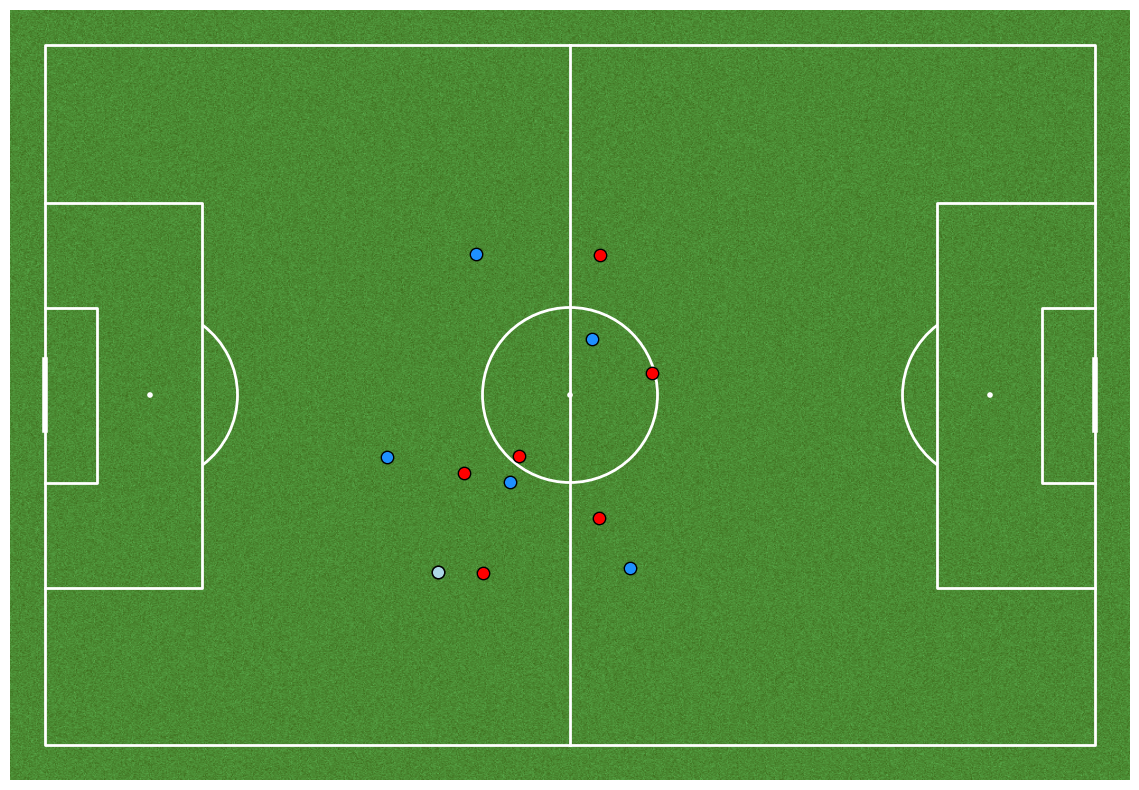

Player:


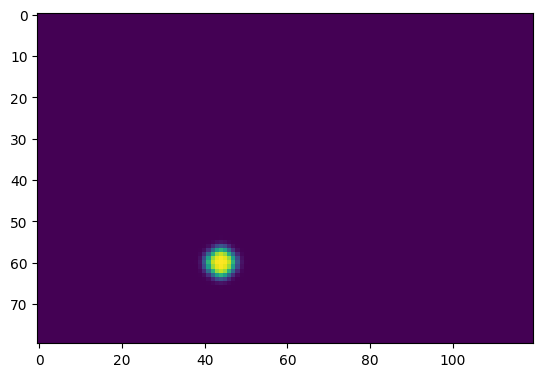

Teammates:


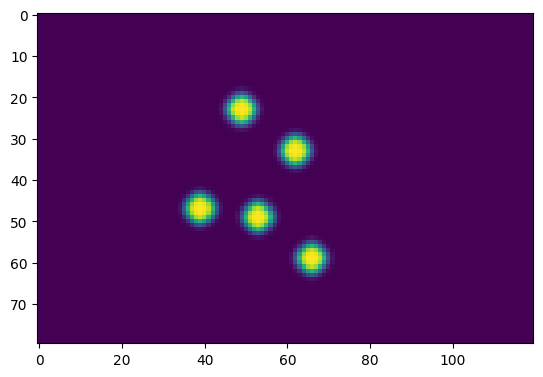

Opponents:


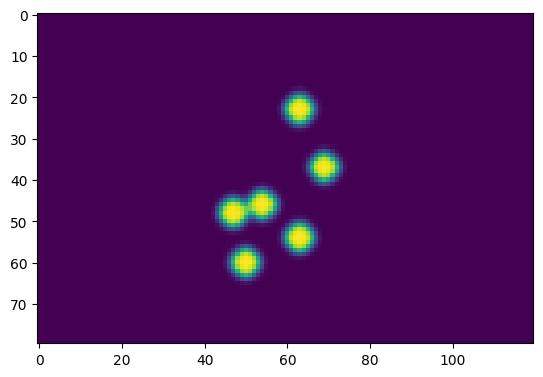

Pitch control:


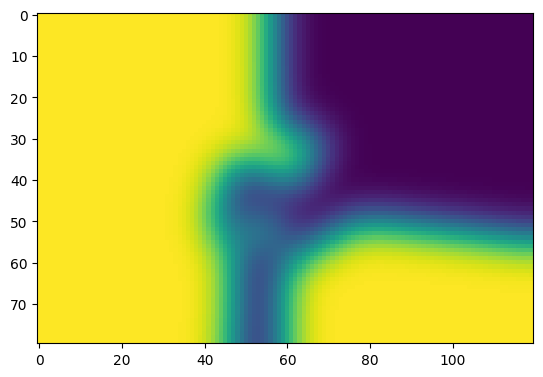

In [9]:
event_ids = passes.id

visualizable_events = frames[frames.id.isin(event_ids)].id.unique()

visualizable_index = 23
visualizable_event = events[events.id == visualizable_events[visualizable_index]]

print(visualizable_index, visualizable_events[visualizable_index])
# print(visualizable_event.columns)
display(visualizable_event.loc[:,["id", "period", "timestamp", "possession_team_name", "pass_angle", "x", "y"]])

player_position_data = frames[frames.id == visualizable_events[visualizable_index]]

actor_locs = player_position_data[player_position_data.actor]
teammate_locs = player_position_data[player_position_data.teammate]
opponent_locs = player_position_data[~player_position_data.teammate]

display(player_position_data)
# print(teammate_locs.loc[:,["teammate", "actor", "keeper", "x", "y"]])
# print(opponent_locs.loc[:,["teammate", "actor", "keeper", "x", "y"]])

## set up pitch
p = Pitch(pitch_color='grass', line_color='white', pitch_type='statsbomb')
fig, ax = p.draw(figsize=(12,8))

if (visualizable_event.possession_team_name.unique())[0] == "Turkey":
    p.scatter(teammate_locs.x, teammate_locs.y, c='red', s=80, ec='k', ax=ax)
    p.scatter(opponent_locs.x, opponent_locs.y, c='dodgerblue', s=80, ec='k', ax=ax)
    p.scatter(actor_locs.x, actor_locs.y, c='pink', s=80, ec='k', ax=ax)
else:
    p.scatter(teammate_locs.x, teammate_locs.y, c='dodgerblue', s=80, ec='k', ax=ax)
    p.scatter(opponent_locs.x, opponent_locs.y, c='red', s=80, ec='k', ax=ax)
    p.scatter(actor_locs.x, actor_locs.y, c='lightblue', s=80, ec='k', ax=ax)
    

plt.savefig("example_pass.png")
plt.show()

positions_tensor = np.load(f"{positions_export_location}/{match_id}/{visualizable_events[visualizable_index]}.npy")
plt.imshow(positions_tensor[0])
plt.savefig("example_pass_player.png")
print("Player:")
plt.show()

plt.imshow(positions_tensor[1])
plt.savefig("example_pass_teammates.png")
print("Teammates:")
plt.show()

plt.imshow(positions_tensor[2])
plt.savefig("example_pass_opponents.png")
print("Opponents:")
plt.show()

plt.imshow(positions_tensor[3])
plt.savefig("example_pass_pitch.png")
print("Pitch control:")
plt.show()


## Passes and 360 availability

In [14]:
pass_360_stats = {"Passes": [], "360 available": []}

for match_folder in tqdm(glob.glob(f"{positions_export_location}/*")):
    time.sleep(1)
    match_id = match_folder.replace(f"{positions_export_location}\\", "")
    available = [event.replace(f"{positions_export_location}\\{match_id}\\", "").replace(".npy", "") for event in glob.glob(f"{positions_export_location}\\{match_id}\\*.npy")]
    pass_360_stats["360 available"].append(len(available))
    
    events, related, freeze, tactics = parser.event(match_id)
    passes = events[events.type_id == 30]
    pass_360_stats["Passes"].append(len(passes))
    
pass_360_stats = pd.DataFrame(pass_360_stats)
pass_360_stats.loc[:,"Available %"] = pass_360_stats["360 available"]/pass_360_stats.Passes

pass_360_stats.describe()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


,Passes,360 available,Available %
count,100.000000,100.000000,100.000000
mean,1026.540000,870.450000,0.847288
std,154.609735,141.945883,0.040859
min,714.000000,607.000000,0.722958
25%,909.000000,779.750000,0.824189
50%,1018.000000,854.500000,0.852127
75%,1093.500000,935.500000,0.879646
max,1477.000000,1241.000000,0.921301
